# Notebook for MRR processing

By: Claudio Duran-Alarcon - PhD student, IGE

PhD Directors: Brice Boudevillain, Alexis Berne

Project: ANR-APRES3, Director: Christophe Genthon

Contact: claudioduran@ug.uchile.cl, Claudio.duran@univ-grenoble-alpes.fr

## Importing libraries

In [1]:
import sys, os
sys.path.append("lib/") # adding lib path
from MRR_functions import check_RawFiles as crf  # Check Raw files for corrupted characters
from MRR_functions import raw2snow # Process raw data into Doppler moments using MK2012
from MRR_functions import densplot # 2D density plots
from MRR_functions import QuickL #MRR QuickLooks
from MRR_functions import mkfolders # create output folders
from MRR_functions import find_dates_btw #Make a list of day between two dates
from MRR_functions import plot_spectra #Displays the spectra for a given time +/- a temporal window
import time, warnings
import matplotlib.pyplot as plt
from netCDF4 import Dataset # Read and write ncCDF files
from netCDF4 import MFDataset # Read Multiple netCDF files
from MRR_functions import MFDataset_save # Saves Multiple netCDF files
import numpy as np

### USER parameters

In [2]:
#warnings.filterwarnings("ignore") #Ignore IMProToo warmings
Short_name_station = "DDU" #Define folter station name
name_station = '_'.join(Short_name_station.split(' '))
path = "Data/"+name_station+"/"

#Graphic parameters
font = {'family'    :   'serif',
        'weight'    :   'normal',
        'size'      :   20}
plt.rc('font', **font)        

#Creating output folders
mkfolders()

#Decription of the output files
Descr = "MRR data at " + name_station + ", first MRR processed with MK12 method v.0.103."

#Temporal Resolution
TRES = 60 #Seconds

#Define Dates
#years =  [2017] # e.g.  [2014];  [2014,2015];  range(2014,2016)   
#months = [2] # e.g.  [12];  [4,5,6];  range(1,13)   
#days  = [8,9,10]#range(8,9)# e.g. [1];  [1,2,4];  range(1,5)   

date_ini = '2020-01-01'
date_end = '2020-01-31'

epochs, timestamps = find_dates_btw(date_ini,date_end)            

# Z-S relationship
## Z = A*S^B
## Experimental parameters for DDU according to Grazioli et al. (2017)
A = 76
B = 0.91 

## Xband Correction
a = 0.99
b = 6.14

## Process data

### Process all the files within the defined period of dates

In [20]:
threshold0 = a*np.linspace(-14,-8,31)+b # Considered a lineal threshold for Ze from -14 (lowest level) to -8 (hightest level) dBZe

for timestamp in timestamps:
    
    year=timestamp[:4] 
    month=timestamp[4:6] 
    day=timestamp[6:8]
    file_in = path+"RawSpectra/"+str(year)+str(month).zfill(2)+"/"+str(month).zfill(2)+str(day).zfill(2)+".raw"
    file_out = path+"MK_processed/"+str(year)+str(month).zfill(2)+"/"+name_station+"_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(int(TRES))+"TRES.nc"
    temp_file = path+"temp/rawfile.raw"

    if (os.path.isfile(file_in) == True): #Processes the data if file exists

        if (os.path.isfile(file_out) == False): #Processes the data only once

            if os.path.exists(os.path.dirname(file_out)) == False: os.mkdir(os.path.dirname(file_out)) #Make output folder if it does not exist

            n_errors = crf(file_in, temp_file) #Check for particular characters in the rawfiles that stops the post-processing

            if n_errors > 0: 
                time.sleep(5) #Gives times to the temporal file, ti be created
                raw2snow(temp_file,file_out, TRES = TRES, Descr = Descr) # Convert Raw into Doppler Moments using MK2012
                time.sleep(5)  

                ds = Dataset(file_out,'a')
                Ze = ds.variables["Ze"][:]
                
                threshold = np.zeros(shape = np.shape(Ze))
                for i in range(np.shape(Ze)[0]):
                    threshold[i,:] = threshold0
                
                S2 = np.ma.masked_where(Ze < threshold,S)    
                
                Ze = np.ma.masked_where(Ze < threshold, Ze) #Min Ze threshold for precipitation at 1minute
                S = ds.createVariable('S', 'f', ('time', 'range',),fill_value=-9999.)
                S[:] = ((10**((a*Ze+b)/10.))/(1.*A))**(1./B) 
                S.description = "Snowfall rate derived from S-Ze relationship in Grazioli et al. (2017, TC)"
                S.units = "mm/h"
                ds.close()                                                

            else:
                time.sleep(5) #Gives times to the temporal file, ti be created
                raw2snow(file_in,file_out, TRES = TRES, Descr = Descr)

                ds = Dataset(file_out,'a')
                Ze = ds.variables["Ze"][:]

                threshold = np.zeros(shape = np.shape(Ze))
                for i in range(np.shape(Ze)[0]):
                    threshold[i,:] = threshold0
                
                Ze = np.ma.masked_where(Ze < threshold, Ze) #Min Ze threshold for precipitation at 1minute
                S = ds.createVariable('S', 'f', ('time', 'range',),fill_value=-9999.)
                S[:] = ((10**((a*Ze+b)/10.))/(1.*A))**(1./B) 
                S.description = "Snowfall rate derived from S-Ze relationship in Grazioli et al. (2017, TC)"
                S.units = "mm/h"
                ds.close()                        
                time.sleep(5)                              
        else:
            print "NetCDF file ready "+str(year)+"/"+str(month).zfill(2)+"/"+str(day).zfill(2)+"_"+str(int(TRES))+"TRES"
    else:
        print "Raw file not found "+str(year)+"/"+str(month).zfill(2)+"/"+str(day).zfill(2)

1 of 1: Data/DDU/RawSpectra/202001/0101.raw
No Data at 2020-01-01 01:34:00
NetCDF file ready 2020/01/02_60TRES
NetCDF file ready 2020/01/03_60TRES
NetCDF file ready 2020/01/04_60TRES
NetCDF file ready 2020/01/05_60TRES
NetCDF file ready 2020/01/06_60TRES
NetCDF file ready 2020/01/07_60TRES
NetCDF file ready 2020/01/08_60TRES
NetCDF file ready 2020/01/09_60TRES
NetCDF file ready 2020/01/10_60TRES
NetCDF file ready 2020/01/11_60TRES
NetCDF file ready 2020/01/12_60TRES
NetCDF file ready 2020/01/13_60TRES
NetCDF file ready 2020/01/14_60TRES
NetCDF file ready 2020/01/15_60TRES
NetCDF file ready 2020/01/16_60TRES
NetCDF file ready 2020/01/17_60TRES
NetCDF file ready 2020/01/18_60TRES
NetCDF file ready 2020/01/19_60TRES
NetCDF file ready 2020/01/20_60TRES
NetCDF file ready 2020/01/21_60TRES
NetCDF file ready 2020/01/22_60TRES
NetCDF file ready 2020/01/23_60TRES
NetCDF file ready 2020/01/24_60TRES
NetCDF file ready 2020/01/25_60TRES
NetCDF file ready 2020/01/26_60TRES
NetCDF file ready 2020/01

## Quicklooks

In [ ]:
#for timestamp in timestamps:            
#    QuickL(year=timestamp[:4], month=timestamp[4:6], day=timestamp[6:8], path=path, name_station = 'DDU',TRES = TRES, Ze_ranges = [-20, 20],W_ranges = [-3, 3], SW_ranges = [0, 1], S_ranges = [0, 0.5], cmap = 'jet',format = 'png',dpi=300)        

## Merging netCDF files



In [54]:
ds_names = []

file_out = 'Data/DDU/MK_processed/TimeMerged/MRR_merged_'+timestamps[0]+'-'+timestamps[-1]+"_"+str(int(TRES))+'TRES.nc'

for timestamp in timestamps:

    file_in = path+"MK_processed/"+timestamp[:6]+"/"+name_station+"_"+timestamp+"_"+str(int(TRES))+"TRES.nc"

    if (os.path.isfile(file_in) == True): #Processes the data only if it exists

        ds = Dataset(file_in)  
        ds_names.append(file_in)                    
        ds.close()

ds_merged = MFDataset(ds_names)

times = ds_merged.variables["time"][:]
height = ds_merged.variables["height"][:]
Ze = ds_merged.variables["Ze"][:]
W =  ds_merged.variables["W"][:]
SW = ds_merged.variables["spectralWidth"][:]
S = ds_merged.variables["S"][:]

#saves MFDataset
if (os.path.isfile(file_out) == False): #Processes the data only once
    MFDataset_save(file_out,ds_merged)

In [ ]:
#Intregrate in 1h
import time
from calendar import timegm

utc_time1 = time.strptime("2020-01-01 01:00:00", "%Y-%m-%d %H:%M:%S")
epoch_time1 = timegm(utc_time1)
utc_time2 = time.strptime("2020-02-01 00:00:00", "%Y-%m-%d %H:%M:%S")
epoch_time2 = timegm(utc_time2)

times_1h = np.linspace(epoch_time1,epoch_time2,(epoch_time2-epoch_time1)/3600.+1)

S_1h = np.zeros(shape=(np.size(times_1h),31))
n = 0
for t in times_1h:
    
    pix = np.squeeze(np.where((t-3600 < times) & (t >= times)))
    S_1h[n,:] = np.sum(S[pix[0]:pix[-1],:].filled(0),axis=0)/60.
    n = n + 1
    
fig, ax = plt.subplots(figsize=(13,8))

S_1h = np.ma.masked_where(S_1h==0,S_1h)
plt.pcolor((times_1h-times_1h[0])/(24*3600.),height[0,:]/1000.,np.transpose(S_1h),vmin=0,vmax=3,cmap='jet')
pt=plt.colorbar(label='Snowfall rate [mm h'+r'$^{-1}$'+']')
plt.xticks(np.linspace(5,30,6))
plt.xlabel('Time [Days]')
plt.ylabel('Height [km a.g.l.]')
plt.title('Snowfall rate January 2020')
plt.show()

fig, ax = plt.subplots(figsize=(13,8))

S_1h = np.ma.masked_where(S_1h==0,S_1h)
plt.pcolor((times_1h-times_1h[0])/(3600.),height[0,:]/1000.,np.transpose(S_1h),vmin=0,vmax=3,cmap='jet')
pt=plt.colorbar(label='Snowfall rate [mm h'+r'$^{-1}$'+']')
#plt.xticks(np.linspace(5,30,6))
plt.xlabel('Time [Hours]')
plt.ylabel('Height [km a.g.l.]')
plt.title('MRR snowfall rate January 2020')
plt.savefig("MRR SnowfallRate_January2020.png",bbox_inches='tight')
plt.show()    

## Plots of vertical structure



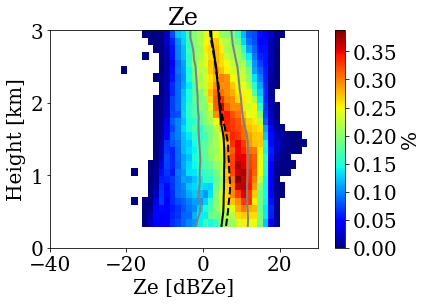

In [8]:
var1 = Ze #dBZe
var2 = height/1000. #km

densplot(var1,var2,title="Ze",bins = [50,31], 
         Range = [[-40,30],[0,3]],
         xlab = 'Ze [dBZe]',
         ylab= 'Height [km]', 
         cbar_label = '%')
plt.show()

#Notes
#Black solid line is the mean vertical profile
#Black dashed line is the median vertical profile (50% quantile)
#Gray lines are the 20 and 80% Quantiles

## Plots of Doppler spectra, VPR and VPV

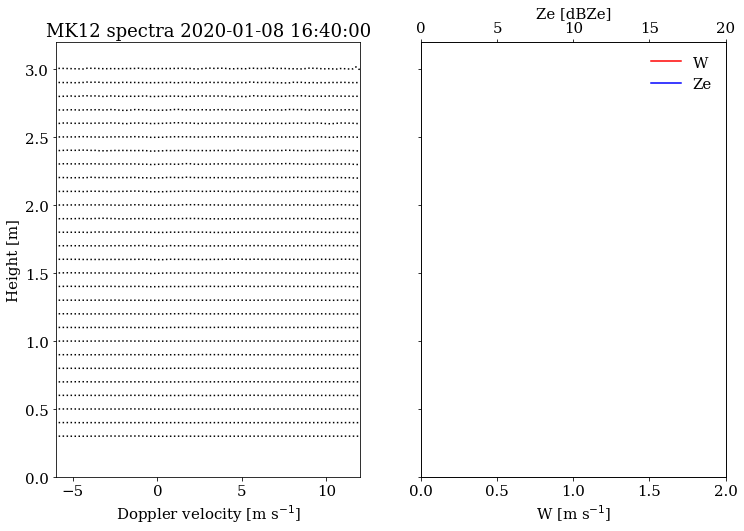

In [9]:
plot_spectra(date_central="2020-01-08 16:40:00",tw=3,e_factor=0.1,mMZe=[0,20],mMW=[0,2])
#date_central = Date of interest in format "%Y-%m-%d %H:%M:%S"
#tw = temporal window befor and after the date_central in the temporal resolution (TRES) of the file. Default 60s, to be improved
#e_factor = exaggeration factor, gives more or vertical height to the spectra   
#mMZe =  min and Max Ze
#mMW = min and Max W